In [4]:
from gluonts.dataset.split import split
from gluonts.torch import DeepAREstimator
from gluonts.dataset.pandas import PandasDataset
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import pandas as pd

load_dotenv()

True

In [5]:

from data.get_data import get_data_frame, get_max_user_count, get_library_count
from gluonts.dataset.common import ListDataset

In [6]:
df = get_data_frame(1)

Connected to database
[(datetime.datetime(2023, 11, 24, 13, 0), 1114), (datetime.datetime(2023, 11, 24, 13, 15), 1130), (datetime.datetime(2023, 11, 24, 13, 30), 1165), (datetime.datetime(2023, 11, 24, 13, 45), 1201), (datetime.datetime(2023, 11, 24, 14, 0), 1250), (datetime.datetime(2023, 11, 24, 14, 15), 1294), (datetime.datetime(2023, 11, 24, 14, 30), 1335), (datetime.datetime(2023, 11, 24, 14, 45), 1354), (datetime.datetime(2023, 11, 24, 15, 0), 1336), (datetime.datetime(2023, 11, 24, 15, 15), 1346), (datetime.datetime(2023, 11, 24, 15, 30), 1343), (datetime.datetime(2023, 11, 24, 15, 45), 1340), (datetime.datetime(2023, 11, 24, 16, 0), 1316), (datetime.datetime(2023, 11, 24, 16, 15), 1287), (datetime.datetime(2023, 11, 24, 16, 30), 1210), (datetime.datetime(2023, 11, 24, 16, 45), 1157), (datetime.datetime(2023, 11, 24, 17, 0), 1124), (datetime.datetime(2023, 11, 24, 17, 15), 1041), (datetime.datetime(2023, 11, 24, 17, 30), 946), (datetime.datetime(2023, 11, 24, 17, 45), 864), (dat

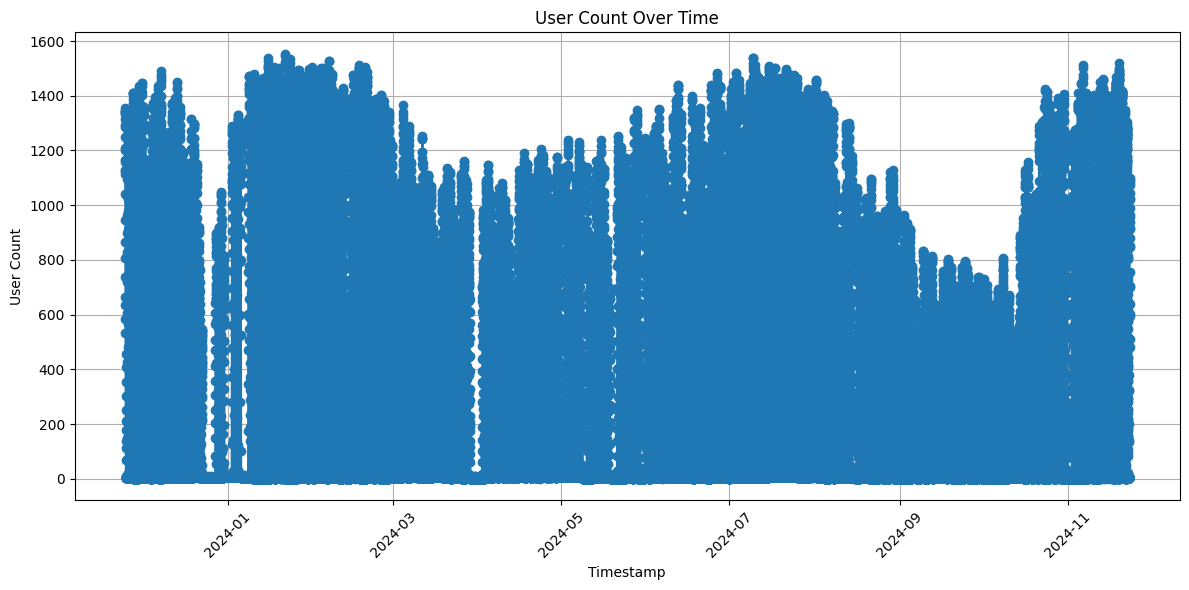

In [7]:
df.set_index('timestamp', inplace=True)

# Plot the time series data
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['user_count'], marker='o', linestyle='-')
plt.title('User Count Over Time')
plt.xlabel('Timestamp')
plt.ylabel('User Count')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [8]:
print(get_max_user_count(df))
print(df.size)

1382.0
36385


In [15]:
from gluonts.torch import DeepAREstimator
from gluonts.torch.model.deepar import DeepARLightningModule
from gluonts.torch.model.estimator import PyTorchLightningEstimator
import pandas as pd
from gluonts.dataset.common import ListDataset

import torch
from gluonts.model.predictor import Predictor
from pathlib import Path
import os
print(df.head())

freq = "15min"

prediction_length = 96

train_ds = ListDataset(
    [{"start": df.index[0], "target": df['user_count'].values}],
    freq=freq
)

estimator = DeepAREstimator(
    prediction_length=prediction_length,
    freq=freq,
    context_length=prediction_length * 4, 
    num_layers=2,
    hidden_size=40,
    dropout_rate=0.1,
    trainer_kwargs={"max_epochs": 1}  
)


model_save_path = Path("./models")

if not model_save_path.exists():
    os.makedirs(model_save_path)

predictor = estimator.train(train_ds)

predictor.serialize(model_save_path)

test_ds = ListDataset(
    [{"start": df.index[0], "target": df['user_count'].values}],
    freq=freq
)

forecasts = list(predictor.predict(test_ds))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


                     user_count
timestamp                      
2023-11-24 13:00:00        1114
2023-11-24 13:15:00        1130
2023-11-24 13:30:00        1165
2023-11-24 13:45:00        1201
2023-11-24 14:00:00        1250


c:\Users\jonassuess\AppData\Local\pypoetry\Cache\virtualenvs\nerf-cement-WQ2jQSKF-py3.12\Lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name  | Type        | Params | Mode  | In sizes                                                         | Out sizes   
--------------------------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 27.0 K | train | [[1, 1], [1, 1], [1, 1056, 6], [1, 1056], [1, 1056], [1, 96, 6]] | [1, 100, 96]
--------------------------------------------------------------------------------------------------------------------------------
27.0 K    Trainable params
0         Non-trainable params
27.0 K    Total params
0.108     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 50: 'train_loss' reached 6.79199 (best 6.79199), saving model to 'c:\\Users\\jonassuess\\develop\\bibradar\\ml\\lightning_logs\\version_17\\checkpoints\\epoch=0-step=50.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=1` reached.


In [ ]:
import matplotlib.pyplot as plt

plt.plot(df.index, df['user_count'], label="True values", color="black")

for forecast in forecasts:
    plt.plot(forecast.index, forecast.mean, label="Forecast", linestyle='--')

plt.xlabel('Time')
plt.ylabel('User Count')
plt.title('User Count Over Time')
plt.legend()
plt.show()

In [ ]:
from gluonts.evaluation import make_evaluation_predictions
import numpy as np
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=96,  # number of sample paths we want for evaluation
)

forecasts = list(forecast_it)
tss = list(ts_it)

ts_entry = tss[0]
np.array(ts_entry[:5]).reshape(
    -1,
)

dataset_test_entry = next(iter(test_ds))
dataset_test_entry["target"][:5]

forecast_entry = forecasts[0]

print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")

print(f"Mean of the future window:\n {forecast_entry.mean}")
print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")

plt.plot(ts_entry[-150:].to_timestamp())
forecast_entry.plot(show_label=True)
plt.legend()

In [16]:
def predict_one_day(model, df, start_timestamp):
    """
    Predicts the user count for a complete day (96 15-minute intervals) starting from the given timestamp.

    Parameters:
    - model: The trained DeepAREstimator model.
    - df: The DataFrame containing the historical data.
    - start_timestamp: The starting timestamp for the prediction.

    Returns:
    - A list of predicted values for the next 24 hours (96 timestamps).
    """
    prediction_length = 96  
    freq = "15min" 

    # Prepare the input data for prediction
    input_data = ListDataset(
        [{"target": df['user_count'].values, "start": pd.Period(start_timestamp, freq=freq)}],
        freq=freq
    )

    forecasts = list(model.predict(input_data))

    forecast_entry = forecasts[0]
    predicted_values = forecast_entry.mean[:prediction_length]  

    return predicted_values

[ 890.6234   976.9121   959.36115  941.718    956.7837   938.74915
  946.723    951.54175 1042.0692   973.8649   916.9627   876.36975
  903.577    921.6321   906.3471   898.83514  888.5031   978.2611
 1000.74536  995.81647  955.84796  988.8535   940.3963   893.73486
  990.0558   988.1804  1031.6407  1016.49976  989.04315  988.4827
 1040.266    954.1792  1035.4369  1037.2762  1017.1831   921.87256
  992.1675  1005.2785  1017.7098  1011.31604  982.159    921.28406
  886.9171  1048.0339   944.51166 1030.8954   984.4757  1045.7133
 1046.3817  1063.9664  1004.97266  995.0989   983.6021  1066.0842
 1014.96936 1047.1459  1081.6351  1014.88635 1041.5084   986.19244
 1027.9589   999.7745  1057.7085   974.3137  1026.8126   989.77026
 1011.6761  1069.2833  1027.1738   992.9654  1017.3299   958.99927
  977.0879   985.04834 1025.6151   936.2877   939.2212   930.6922
  960.1294   939.4735   901.06323  875.73016  874.36865  846.2642
  847.2665   856.14124  813.8315   798.81256  810.1261   819.3244
  

C:\Users\jonassuess\AppData\Local\Temp\ipykernel_17340\2944429859.py:5: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  date_range = pd.date_range(start="2024-11-23 12:00:00", periods=96, freq='15T')


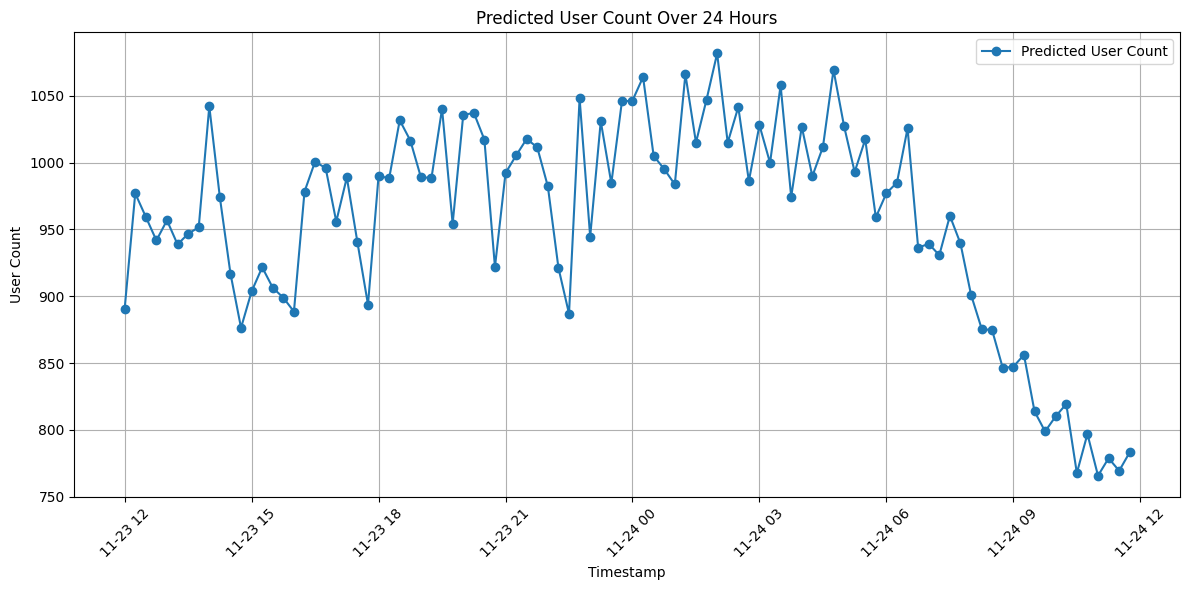

In [17]:
f = predict_one_day(predictor, df, "2024-11-23 12:00:00")
print(f)
print(len(f))

date_range = pd.date_range(start="2024-11-23 12:00:00", periods=96, freq='15T')

plt.figure(figsize=(12, 6))
plt.plot(date_range, f, marker='o', linestyle='-', label='Predicted User Count')
plt.title('Predicted User Count Over 24 Hours')
plt.xlabel('Timestamp')
plt.ylabel('User Count')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

